Displayed frame: 09-08-2025_00-43-24_3167.png
Image size: (200, 200)
Tensor shape: (200, 200)
Tensor dtype: float32
Min value: 0.0, Max value: 255.0

Black channel tensor (200x200):
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [ 38.  42.   0. ...   0. 113. 105.]
 [ 21.  49.  42. ...  55. 164. 123.]
 [ 21.  21.  38. ...  38. 149. 185.]]


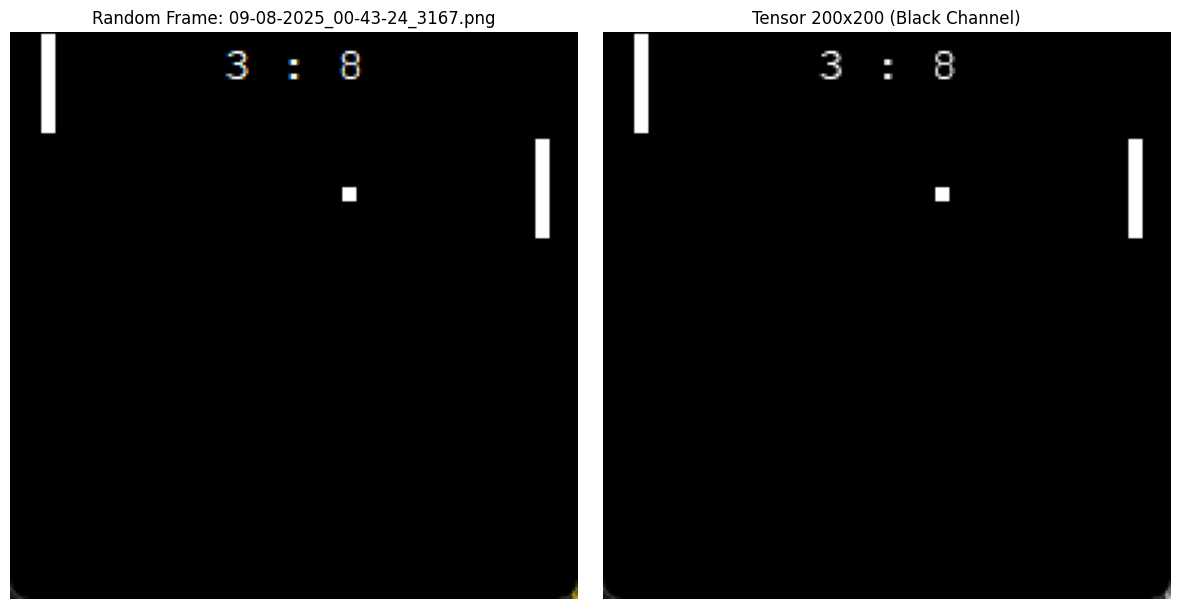

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get the frames directory
frames_dir = "frames"

# Check if frames directory exists
if not os.path.exists(frames_dir):
    print(f"Frames directory '{frames_dir}' not found!")
else:
    # Get all PNG files in the frames directory
    frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.png')]
    
    if not frame_files:
        print("No PNG files found in frames directory!")
    else:
        # Select a random frame
        random_frame = random.choice(frame_files)
        frame_path = os.path.join(frames_dir, random_frame)
        
        # Load and display the image
        img = Image.open(frame_path)
        
        print(f"Displayed frame: {random_frame}")
        print(f"Image size: {img.size}")

        
        # Convert image to tensor and extract black channel
        import numpy as np
        
        # Convert PIL image to numpy array
        img_array = np.array(img)
        
        # Check if image is RGB or RGBA
        if len(img_array.shape) == 3:
            black_channel = img_array[:, :, 0]
        else:
            # If it's already grayscale
            black_channel = img_array
        
        # Convert to tensor (numpy array) and ensure it's 200x200
        tensor_200x200 = black_channel.astype(np.float32)
        
        print(f"Tensor shape: {tensor_200x200.shape}")
        print(f"Tensor dtype: {tensor_200x200.dtype}")
        print(f"Min value: {tensor_200x200.min()}, Max value: {tensor_200x200.max()}")
        print("\nBlack channel tensor (200x200):")
        print(tensor_200x200)

        # Display both images as subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(img)
        ax1.set_title(f"Random Frame: {random_frame}")
        ax1.axis('off')
        
        ax2.imshow(tensor_200x200, cmap='gray', vmin=0, vmax=255)
        ax2.set_title("Tensor 200x200 (Black Channel)")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RealTimePongPredictor(nn.Module):
    """
    Lightweight U-Net for real-time next-frame prediction in Pong
    Optimized for <16ms inference time on GPU for 60fps gameplay
    """
    def __init__(self):
        super(RealTimePongPredictor, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self._conv_block(2, 32)       # Input: 2 frames (t-1, t)
        self.enc2 = self._conv_block(32, 64)      # 100x100 -> 100x100  
        self.enc3 = self._conv_block(64, 128)     # 50x50 -> 50x50
        
        # Bottleneck
        self.bottleneck = self._conv_block(128, 256)  # 25x25 -> 25x25
        
        # Decoder (upsampling) with skip connections
        self.dec3 = self._conv_block(256 + 128, 128)  # +128 from skip connection
        self.dec2 = self._conv_block(128 + 64, 64)    # +64 from skip connection  
        self.dec1 = self._conv_block(64 + 32, 32)     # +32 from skip connection
        
        # Final output layer
        self.final = nn.Conv2d(32, 1, kernel_size=1)
        
    def _conv_block(self, in_channels, out_channels):
        """Lightweight convolution block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """
        Args:
            x: Concatenated input frames [batch_size, 2, 200, 200] where x[:,0]=t-1, x[:,1]=t
        Returns:
            next_frame: Predicted next frame [batch_size, 1, 200, 200]
        """
        # Encoder with skip connections
        e1 = self.enc1(x)           # [B, 32, 200, 200]
        e1_pool = F.max_pool2d(e1, 2)  # [B, 32, 100, 100]
        
        e2 = self.enc2(e1_pool)     # [B, 64, 100, 100]
        e2_pool = F.max_pool2d(e2, 2)  # [B, 64, 50, 50]
        
        e3 = self.enc3(e2_pool)     # [B, 128, 50, 50]
        e3_pool = F.max_pool2d(e3, 2)  # [B, 128, 25, 25]
        
        # Bottleneck
        bottleneck = self.bottleneck(e3_pool)  # [B, 256, 25, 25]
        
        # Decoder with skip connections
        d3 = F.interpolate(bottleneck, size=(50, 50), mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)  # Skip connection
        d3 = self.dec3(d3)  # [B, 128, 50, 50]
        
        d2 = F.interpolate(d3, size=(100, 100), mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)  # Skip connection
        d2 = self.dec2(d2)  # [B, 64, 100, 100]
        
        d1 = F.interpolate(d2, size=(200, 200), mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)  # Skip connection
        d1 = self.dec1(d1)  # [B, 32, 200, 200]
        
        # Predict residual delta in [-1,1], then add to latest frame
        residual = torch.tanh(self.final(d1))  # [B, 1, 200, 200]
        latest = x[:, 1:2, :, :]               # most recent frame
        output = torch.clamp(latest + residual, 0.0, 1.0)
        
        return output

# Create model instance
model = RealTimePongPredictor()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (FP32)")

# Test inference speed
if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)
    print(f"Using GPU: {torch.cuda.get_device_name()}")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Benchmark inference speed
import time
model.eval()
with torch.no_grad():
    # Warmup - FIXED: Use 2 channels input as expected by the model
    for _ in range(10):
        dummy_input = torch.randn(1, 2, 200, 200).to(device)  # Changed to 200x200
        _ = model(dummy_input)
    
    # Actual timing - FIXED: Use 2 channels input as expected by the model
    times = []
    for _ in range(200):
        dummy_input = torch.randn(1, 2, 200, 200).to(device)  # Changed to 200x200
        start_time = time.time()
        output = model(dummy_input)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end_time = time.time()
        times.append((end_time - start_time) * 1000)  # Convert to milliseconds
    
    avg_time = sum(times) / len(times)
    print(f"\nInference Performance:")
    print(f"Average inference time: {avg_time:.2f} ms")
    print(f"Theoretical max FPS: {1000/avg_time:.1f}")
    print(f"Real-time capable (60fps): {'✓ YES' if avg_time < 16.67 else '✗ NO'}")
    print(f"Output shape: {output.shape}")


Model created successfully!
Total parameters: 1,949,409
Trainable parameters: 1,949,409
Model size: ~7.4 MB (FP32)
Using GPU: NVIDIA GeForce RTX 4070 SUPER

Inference Performance:
Average inference time: 1.57 ms
Theoretical max FPS: 637.5
Real-time capable (60fps): ✓ YES
Output shape: torch.Size([1, 1, 200, 200])


In [23]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path

class PongSequenceDataset(Dataset):
    """
    Dataset for loading consecutive Pong frames for next-frame prediction
    """
    def __init__(self, frames_dir="frames", sequence_length=3):
        self.frames_dir = Path(frames_dir)
        self.sequence_length = sequence_length
        
        # Get all frame files and sort them by timestamp
        self.frame_files = sorted([f for f in self.frames_dir.glob("*.png")])
        
        # Group frames by recording session (same timestamp prefix)
        self.sequences = self._group_sequences()
        
        print(f"Found {len(self.frame_files)} total frames")
        print(f"Created {len(self.sequences)} valid sequences")
    
    def _group_sequences(self):
        """Group frames into sequences by timestamp"""
        sequences = []
        current_session = []
        current_prefix = None
        
        for frame_file in self.frame_files:
            # Extract timestamp prefix (everything before the frame number)
            parts = frame_file.stem.split('_')
            if len(parts) >= 3:
                prefix = '_'.join(parts[:-1])  # All parts except the last (frame number)
                
                if current_prefix is None or prefix == current_prefix:
                    current_session.append(frame_file)
                    current_prefix = prefix
                else:
                    # New session started, process previous session
                    if len(current_session) >= self.sequence_length:
                        for i in range(len(current_session) - self.sequence_length + 1):
                            sequences.append(current_session[i:i + self.sequence_length])
                    
                    # Start new session
                    current_session = [frame_file]
                    current_prefix = prefix
        
        # Process the last session
        if len(current_session) >= self.sequence_length:
            for i in range(len(current_session) - self.sequence_length + 1):
                sequences.append(current_session[i:i + self.sequence_length])
        
        return sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        # Load frames as tensors
        frames = []
        for frame_file in sequence:
            img = Image.open(frame_file)
            # Convert to grayscale tensor
            img_array = np.array(img)
            if len(img_array.shape) == 3:
                img_array = img_array[:, :, 0]  # Use first channel
            
            # Normalize to [0, 1]
            tensor = torch.from_numpy(img_array.astype(np.float32)) / 255.0
            frames.append(tensor.unsqueeze(0))  # Add channel dimension
        
        # Return two input frames and target frame: (t-1, t) -> t+1
        prev_frame = frames[0]
        curr_frame = frames[1]
        target_frame = frames[2]
        
        input_two = torch.cat([prev_frame, curr_frame], dim=0)  # [2, H, W]
        return input_two, target_frame

# Training configuration
class TrainingConfig:
    def __init__(self):
        self.batch_size = 16
        self.learning_rate = 1e-3
        self.num_epochs = 10
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.save_every = 5  # Save model every N epochs
        
config = TrainingConfig()

# Create dataset and dataloader
try:
    dataset = PongSequenceDataset(frames_dir="frames")
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    
    print(f"Dataset created with {len(dataset)} training pairs")
    print(f"Batch size: {config.batch_size}")
    print(f"Training batches per epoch: {len(dataloader)}")
    
    # Test loading a batch
    sample_input, sample_target = next(iter(dataloader))
    print(f"Sample batch shapes - Input(two): {sample_input.shape}, Target: {sample_target.shape}")
    
except Exception as e:
    print(f"Could not create dataset: {e}")
    print("Make sure you have recorded some frames using F1 in the Pong game!")
    dataset = None
    dataloader = None


Found 6496 total frames
Created 6494 valid sequences
Dataset created with 6494 training pairs
Batch size: 16
Training batches per epoch: 406
Sample batch shapes - Input(two): torch.Size([16, 2, 200, 200]), Target: torch.Size([16, 1, 200, 200])


In [24]:
def train_model(model, dataloader, config):
    """
    Training loop for the Pong frame prediction model
    """
    if dataloader is None:
        print("No dataloader available. Please record some frames first!")
        return
    
    # Setup training
    model = model.to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Weighted loss to emphasize white pixels (includes bottom row)
    def weighted_l1_loss(predicted: torch.Tensor, target: torch.Tensor, white_weight: float = 4.0) -> torch.Tensor:
        # target in [0,1]; weight white/intense pixels more
        weights = 1.0 + white_weight * target
        return torch.mean(weights * torch.abs(predicted - target))
    
    criterion = weighted_l1_loss
    
    model.train()
    
    print(f"Starting training on {config.device}")
    print(f"Training for {config.num_epochs} epochs with {len(dataloader)} batches per epoch")
    print("-" * 60)
    
    for epoch in range(config.num_epochs):
        epoch_loss = 0.0
        
        for batch_idx, (input_frames, target_frames) in enumerate(dataloader):
            # Move to device
            input_frames = input_frames.to(config.device)       # [B, 2, H, W]
            target_frames = target_frames.to(config.device)     # [B, 1, H, W]
            
            # Forward pass
            optimizer.zero_grad()
            predicted_frames = model(input_frames)
            
            # Calculate loss (both in [0,1])
            loss = criterion(predicted_frames, target_frames)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{config.num_epochs}, "
                      f"Batch {batch_idx}/{len(dataloader)}, "
                      f"Loss: {loss.item():.6f}")
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1} completed - Average Loss: {avg_loss:.6f}")
        
        # Save model checkpoint
        if (epoch + 1) % config.save_every == 0:
            checkpoint_path = f"pong_model_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")
        
        print("-" * 60)
    
    # Save final model
    final_path = "pong_model_final.pth"
    torch.save(model.state_dict(), final_path)
    print(f"Training completed! Final model saved as: {final_path}")
    
    return model

# Function to visualize predictions
def visualize_predictions(model, dataloader, config, num_samples=4):
    """
    Visualize model predictions vs ground truth
    """
    if dataloader is None:
        print("No dataloader available for visualization!")
        return
    
    model.eval()
    model = model.to(config.device)
    
    with torch.no_grad():
        # Get a batch of samples
        input_frames, target_frames = next(iter(dataloader))
        input_frames = input_frames.to(config.device)
        target_frames = target_frames.to(config.device)
        
        # Make predictions
        predicted_frames = model(input_frames)
        
        # Move to CPU for visualization
        input_frames = input_frames.cpu()
        target_frames = target_frames.cpu()
        predicted_frames = predicted_frames.cpu()
        
        # Plot comparisons
        fig, axes = plt.subplots(3, min(num_samples, len(input_frames)), figsize=(15, 9))
        if min(num_samples, len(input_frames)) == 1:
            axes = axes.reshape(-1, 1)
        
        for i in range(min(num_samples, len(input_frames))):
            # Input frame
            axes[0, i].imshow(input_frames[i, 1], cmap='gray', vmin=0, vmax=1)
            axes[0, i].set_title(f"Input t (latest) {i+1}")
            axes[0, i].axis('off')
            
            # Ground truth next frame
            axes[1, i].imshow(target_frames[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[1, i].set_title(f"Ground Truth {i+1}")
            axes[1, i].axis('off')
            
            # Predicted next frame
            pred_frame = predicted_frames[i, 0]  # Already in [0,1]
            axes[2, i].imshow(pred_frame, cmap='gray', vmin=0, vmax=1)
            axes[2, i].set_title(f"Predicted {i+1}")
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and print metrics
        mse = F.mse_loss(predicted_frames, target_frames).item()
        mae = F.l1_loss(predicted_frames, target_frames).item()
        
        print(f"Prediction Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")

# Ready to train!
print("Training setup complete!")
print("\nTo start training, run:")
print("trained_model = train_model(model, dataloader, config)")
print("\nTo visualize predictions:")
print("visualize_predictions(model, dataloader, config)")


Training setup complete!

To start training, run:
trained_model = train_model(model, dataloader, config)

To visualize predictions:
visualize_predictions(model, dataloader, config)


In [25]:
class RealTimeInference:
    """
    Optimized inference class for real-time gameplay
    """
    def __init__(self, model_path=None, device=None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        # Create model
        self.model = RealTimePongPredictor()
        
        # Load trained weights if available
        if model_path and Path(model_path).exists():
            try:
                state_dict = torch.load(model_path, map_location=self.device)
                self.model.load_state_dict(state_dict)
                print(f"Loaded model from {model_path}")
            except Exception as e:
                print(f"Could not load model from {model_path}: {e}")
                print("Using randomly initialized model")
        else:
            print("No model path provided or file not found. Using randomly initialized model.")
        
        # Optimize for inference
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Enable optimizations
        if torch.cuda.is_available():
            # Enable TensorRT optimizations if available
            try:
                import torch.backends.cudnn as cudnn
                cudnn.benchmark = True
                cudnn.deterministic = False
                print("Enabled CUDNN optimizations")
            except:
                pass
        
        # Pre-allocate tensors for inference
        self.input_tensor = torch.zeros(1, 2, 200, 200, device=self.device)
        
        # Warmup the model
        self._warmup()
        
    def _warmup(self, warmup_iterations=50):
        """Warmup the model for consistent timing"""
        print("Warming up model...")
        with torch.no_grad():
            for _ in range(warmup_iterations):
                dummy_input = torch.randn(1, 2, 200, 200, device=self.device)
                _ = self.model(dummy_input)
        print("Warmup complete!")
    
    def predict_next_frame(self, prev_frame_np, current_frame_np, controls=None):
        """
        Predict next frame from current frame
        
        Args:
            prev_frame_np: numpy array of shape (100, 100) with values 0-255
            current_frame_np: numpy array of shape (100, 100) with values 0-255
            controls: dict with 'up' and 'down' boolean keys (optional)
                     If provided, will overwrite the bottom row pixels
        
        Returns:
            next_frame_np: numpy array of shape (100, 100) with values 0-255
        """
        with torch.no_grad():
            # Convert numpy to tensor
            prev_tensor = torch.from_numpy(prev_frame_np.astype(np.float32)) / 255.0
            curr_tensor = torch.from_numpy(current_frame_np.astype(np.float32)) / 255.0
            prev_tensor = prev_tensor.unsqueeze(0).unsqueeze(0)
            curr_tensor = curr_tensor.unsqueeze(0).unsqueeze(0)
            frame_tensor = torch.cat([prev_tensor, curr_tensor], dim=1).to(self.device)  # [1,2,100,100]
            
            # Apply control encoding if provided (overwrite on latest frame channel)
            if controls is not None:
                bottom_row = torch.zeros(1, 1, 1, 200, device=self.device)
                if controls.get('up', False):
                    bottom_row[0, 0, 0, :50] = 1.0
                if controls.get('down', False):
                    bottom_row[0, 0, 0, 50:] = 1.0
                frame_tensor[:, 1:2, -1:, :] = bottom_row
            
            # Predict next frame
            prediction = self.model(frame_tensor)
            
            # Convert back to numpy
            prediction_np = prediction[0, 0].cpu().numpy()  # Remove batch and channel dims
            prediction_np = np.clip(prediction_np * 255.0, 0, 255).astype(np.uint8)
            
            return prediction_np
    
    def benchmark_inference(self, iterations=1000):
        """Benchmark inference speed"""
        times = []
        dummy_prev_frame = np.random.randint(0, 256, (200, 200), dtype=np.uint8)
        dummy_curr_frame = np.random.randint(0, 256, (200, 200), dtype=np.uint8)
        
        for _ in range(iterations):
            start_time = time.time()
            _ = self.predict_next_frame(dummy_prev_frame, dummy_curr_frame)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        min_time = np.min(times)
        max_time = np.max(times)
        
        print(f"\nInference Benchmark Results ({iterations} iterations):")
        print(f"Average time: {avg_time:.2f} ± {std_time:.2f} ms")
        print(f"Min time: {min_time:.2f} ms")
        print(f"Max time: {max_time:.2f} ms")
        print(f"Theoretical max FPS: {1000/avg_time:.1f}")
        print(f"Real-time capable (60fps): {'✓ YES' if avg_time < 16.67 else '✗ NO'}")
        print(f"Real-time capable (30fps): {'✓ YES' if avg_time < 33.33 else '✗ NO'}")
        
        return avg_time

# Create inference engine
inference_engine = RealTimeInference()

# Benchmark performance
inference_time = inference_engine.benchmark_inference()

print(f"\n{'='*60}")
print("REAL-TIME GENERATIVE PONG MODEL READY!")
print(f"{'='*60}")
print(f"Model size: ~{sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024:.1f} MB")
print(f"Inference time: {inference_time:.2f} ms")
print(f"Device: {inference_engine.device}")
print("\nNext steps:")
print("1. Record training data: Play Pong and press F1 to record frames")
print("2. Train the model: trained_model = train_model(model, dataloader, config)")
print("3. Create generative gameplay integration")


No model path provided or file not found. Using randomly initialized model.
Enabled CUDNN optimizations
Warming up model...
Warmup complete!

Inference Benchmark Results (1000 iterations):
Average time: 2.34 ± 0.62 ms
Min time: 1.67 ms
Max time: 10.21 ms
Theoretical max FPS: 428.1
Real-time capable (60fps): ✓ YES
Real-time capable (30fps): ✓ YES

REAL-TIME GENERATIVE PONG MODEL READY!
Model size: ~7.4 MB
Inference time: 2.34 ms
Device: cuda

Next steps:
1. Record training data: Play Pong and press F1 to record frames
2. Train the model: trained_model = train_model(model, dataloader, config)
3. Create generative gameplay integration


In [26]:
import os
import glob
from datetime import datetime
from PIL import Image

# ===== Continuous Generative Gameplay (ignores controls) =====

def find_model_path():
    """Return best available model path (final first, else latest epoch)."""
    final_path = Path("pong_model_final.pth")
    if final_path.exists():
        return str(final_path)
    # Fallback: latest epoch checkpoint
    ckpts = sorted(glob.glob("pong_model_epoch_*.pth"))
    return ckpts[-1] if ckpts else None


def robust_load_into_inference(inf_engine: RealTimeInference, model_path: str):
    """Load either a raw state_dict or a checkpoint dict into the inference model."""
    if not model_path:
        print("No trained model found. Using random weights (results will be nonsense).")
        return
    try:
        state = torch.load(model_path, map_location=inf_engine.device)
        # Check for checkpoint vs raw state_dict
        if isinstance(state, dict) and "model_state_dict" in state:
            inf_engine.model.load_state_dict(state["model_state_dict"])
            print(f"Loaded checkpoint weights from: {model_path}")
        else:
            inf_engine.model.load_state_dict(state)
            print(f"Loaded state_dict from: {model_path}")
    except Exception as e:
        print(f"Failed to load model from {model_path}: {e}")
        print("Continuing with randomly initialized model.")


def get_seed_frame(frames_dir="frames"):
    """Pick a seed frame if available, else create a simple synthetic seed."""
    if os.path.isdir(frames_dir):
        pngs = sorted([p for p in os.listdir(frames_dir) if p.endswith('.png')])
        if pngs:
            seed_path = os.path.join(frames_dir, pngs[0])
            img = Image.open(seed_path).convert("L")
            return np.array(img, dtype=np.uint8)
    # Create synthetic seed: paddles center, ball center, bottom row off
    frame = np.zeros((200, 200), dtype=np.uint8)
    # left paddle (player)
    frame[82:118, 10:16] = 255
    # right paddle (AI)
    frame[82:118, 184:190] = 255
    # ball
    frame[97:103, 97:103] = 255
    # bottom row zeros (controls off)
    frame[-1, :] = 0
    return frame


def generate_gameplay(output_dir=None, num_frames=1200, save_video=True, fps=60, model_path=None):
    """
    Generate continuous frames by feeding model outputs back as inputs.
    Controls are ignored (bottom row forced to zero each step).
    """
    # Prepare output directory
    if output_dir is None:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = Path(f"generated_{ts}")
    else:
        output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Create inference engine and load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inf = RealTimeInference(model_path=None, device=device)
    if model_path is None:
        model_path = find_model_path()
    robust_load_into_inference(inf, model_path)

    # Get seed
    # Bootstrap two frames: duplicate seed as both prev and current to start
    prev = get_seed_frame()
    current = prev.copy()

    # Optional video writer
    writer = None
    video_path = output_dir / "0gameplay.mp4"
    if save_video:
        try:
            import imageio
            writer = imageio.get_writer(video_path, fps=fps)
        except Exception as e:
            print(f"Could not initialize video writer: {e}")
            print("Frames will still be saved as PNGs. To enable MP4, install: \n"
                  "pip install imageio[ffmpeg]")

    print(f"Generating {num_frames} frames to: {output_dir}")
    print(f"Device: {device}")

    for i in range(num_frames):
        # Force controls off by overriding bottom row via controls param
        # Predict using (prev, curr) -> next (do not override bottom row)
        next_frame = inf.predict_next_frame(prev, current)

        # Save PNG
        out_path = output_dir / f"frame_{i:05d}.png"
        Image.fromarray(next_frame).save(out_path)

        # Append to video if available
        if writer is not None:
            try:
                writer.append_data(next_frame)
            except Exception as e:
                print(f"Video write error at frame {i}: {e}")
                writer = None  # Stop trying

        # Feedback for next step (shift window)
        prev = current
        current = next_frame

        # Light status
        if (i + 1) % 100 == 0:
            print(f"Generated {i + 1}/{num_frames} frames...")

    if writer is not None:
        writer.close()
        print(f"Saved video: {video_path}")

    print("Done.")
    return str(output_dir)

# Example run (uncomment to execute):
# out_dir = generate_gameplay(num_frames=1800, fps=60)
# out_dir


In [27]:
trained_model = train_model(model, dataloader, config)

Starting training on cuda
Training for 10 epochs with 406 batches per epoch
------------------------------------------------------------
Epoch 1/10, Batch 0/406, Loss: 0.260523
Epoch 1/10, Batch 10/406, Loss: 0.022112
Epoch 1/10, Batch 20/406, Loss: 0.013312
Epoch 1/10, Batch 30/406, Loss: 0.007860
Epoch 1/10, Batch 40/406, Loss: 0.004674
Epoch 1/10, Batch 50/406, Loss: 0.007068
Epoch 1/10, Batch 60/406, Loss: 0.003673
Epoch 1/10, Batch 70/406, Loss: 0.003195
Epoch 1/10, Batch 80/406, Loss: 0.002490
Epoch 1/10, Batch 90/406, Loss: 0.002831
Epoch 1/10, Batch 100/406, Loss: 0.002488
Epoch 1/10, Batch 110/406, Loss: 0.002976
Epoch 1/10, Batch 120/406, Loss: 0.002452
Epoch 1/10, Batch 130/406, Loss: 0.002089
Epoch 1/10, Batch 140/406, Loss: 0.002918
Epoch 1/10, Batch 150/406, Loss: 0.002051
Epoch 1/10, Batch 160/406, Loss: 0.001854
Epoch 1/10, Batch 170/406, Loss: 0.003908
Epoch 1/10, Batch 180/406, Loss: 0.003008
Epoch 1/10, Batch 190/406, Loss: 0.003214
Epoch 1/10, Batch 200/406, Loss: 0

In [30]:
out_dir = generate_gameplay(num_frames=1800, fps=30, model_path="pong_model_final.pth")

No model path provided or file not found. Using randomly initialized model.
Enabled CUDNN optimizations
Warming up model...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Warmup complete!
Loaded state_dict from: pong_model_final.pth
Generating 1800 frames to: generated_20250809_011953
Device: cuda
Generated 100/1800 frames...
Generated 200/1800 frames...
Generated 300/1800 frames...
Generated 400/1800 frames...
Generated 500/1800 frames...
Generated 600/1800 frames...
Generated 700/1800 frames...
Generated 800/1800 frames...
Generated 900/1800 frames...
Generated 1000/1800 frames...
Generated 1100/1800 frames...
Generated 1200/1800 frames...
Generated 1300/1800 frames...
Generated 1400/1800 frames...
Generated 1500/1800 frames...
Generated 1600/1800 frames...
Generated 1700/1800 frames...
Generated 1800/1800 frames...
Saved video: generated_20250809_011953\0gameplay.mp4
Done.
